## Disease prediction from drug reviews


Given Drug reviews by various customers we predict the customer's disease(Diabetes, Birth Control Depression, High Blood Pressure). We will be doing prepocess the text,then first implement bag of words approach then the term frequency method model of three types trigram, bigram and unigram language models and compare it's performances

## Importing libraries

In [1]:
import pandas as pd # data preprocessing
import itertools # confusion matrix
import string
import pandas as pd
import json
import gc
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
# To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)

In [2]:
df=pd.read_csv('drugsComTrain_raw.tsv', sep='\t')

In [3]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [4]:
df.condition.value_counts()

Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                                     2321

In [5]:
df_train = df[(df['condition']=='Birth Control') | (df['condition']=='Depression') | (df['condition']=='High Blood Pressure')|(df['condition']=='Diabetes, Type 2')]

In [6]:
df.shape

(161297, 7)

In [7]:
df_train.shape

(42732, 7)

In [8]:
X = df_train.drop(['Unnamed: 0','drugName','rating','date','usefulCount'],axis=1)

## EDA

In [9]:
X.condition.value_counts()

Birth Control          28788
Depression              9069
Diabetes, Type 2        2554
High Blood Pressure     2321
Name: condition, dtype: int64

In [10]:
X.head()

,condition,review
2,Birth Control,"""I used to take another oral contraceptive, wh..."
3,Birth Control,"""This is my first time using any form of birth..."
9,Birth Control,"""I had been on the pill for many years. When m..."
11,Depression,"""I have taken anti-depressants for years, with..."
14,Birth Control,"""Started Nexplanon 2 months ago because I have..."


In [11]:
# segregating dataframe for analyzing individual condition
X_birth=X[(X['condition']=='Birth Control')]
X_dep=X[(X['condition']=='Depression')]
X_bp=X[(X['condition']=='High Blood Pressure')]
X_diab=X[(X['condition']=='Diabetes, Type 2')]

Text(0.5, 1.0, 'Word cloud for Birth control')

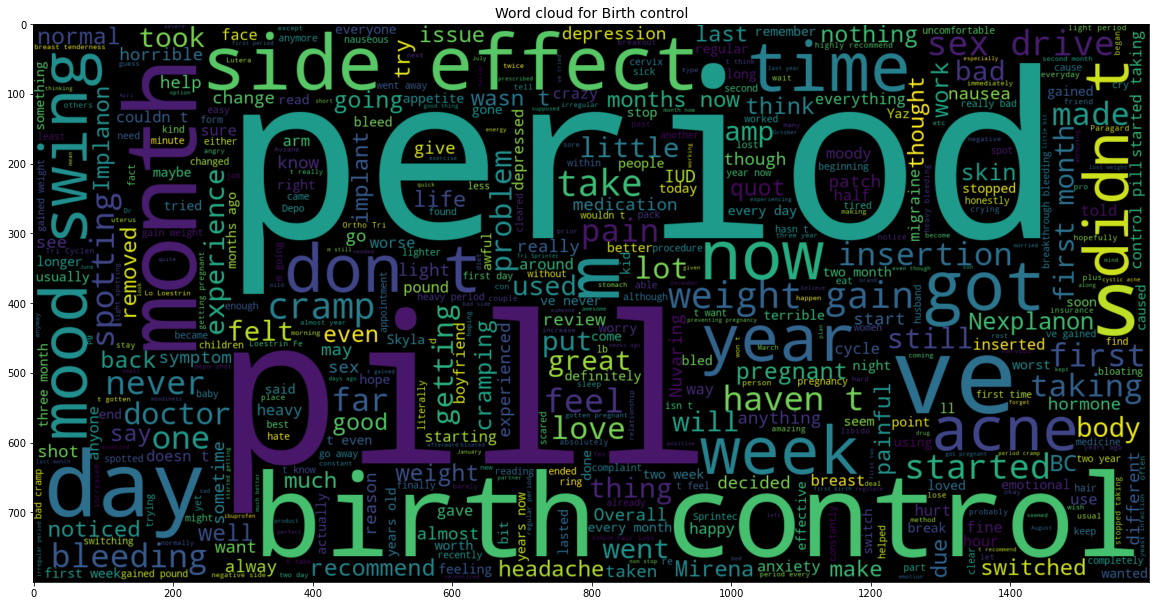

In [12]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_birth.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Birth control',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Depression')

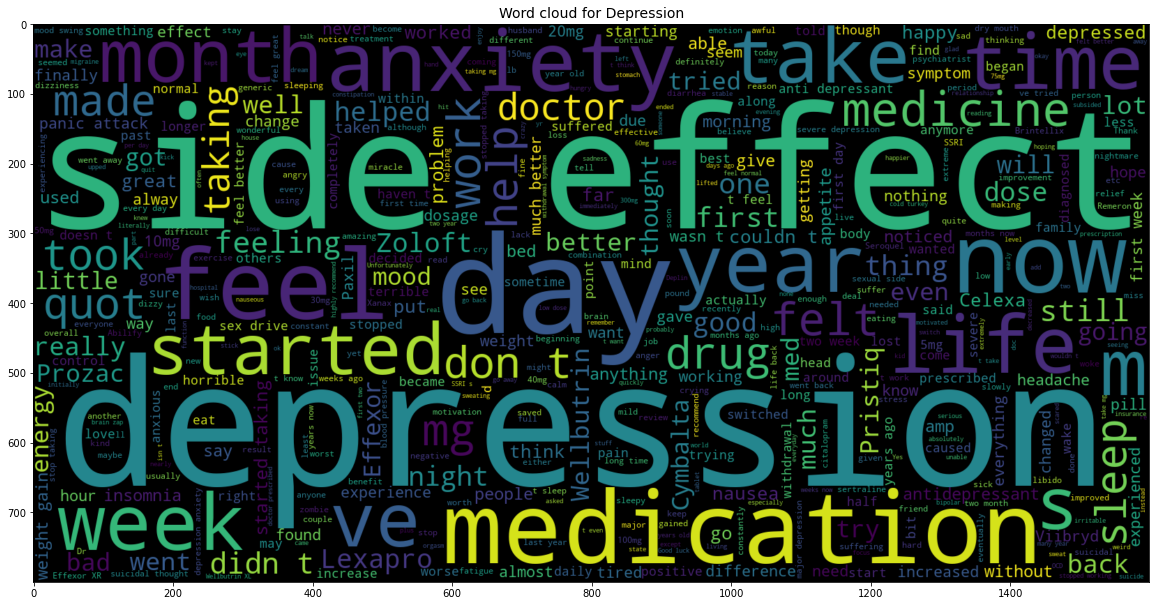

In [13]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_dep.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Depression',fontsize=14)

Text(0.5, 1.0, 'Word cloud for High Blood Pressure')

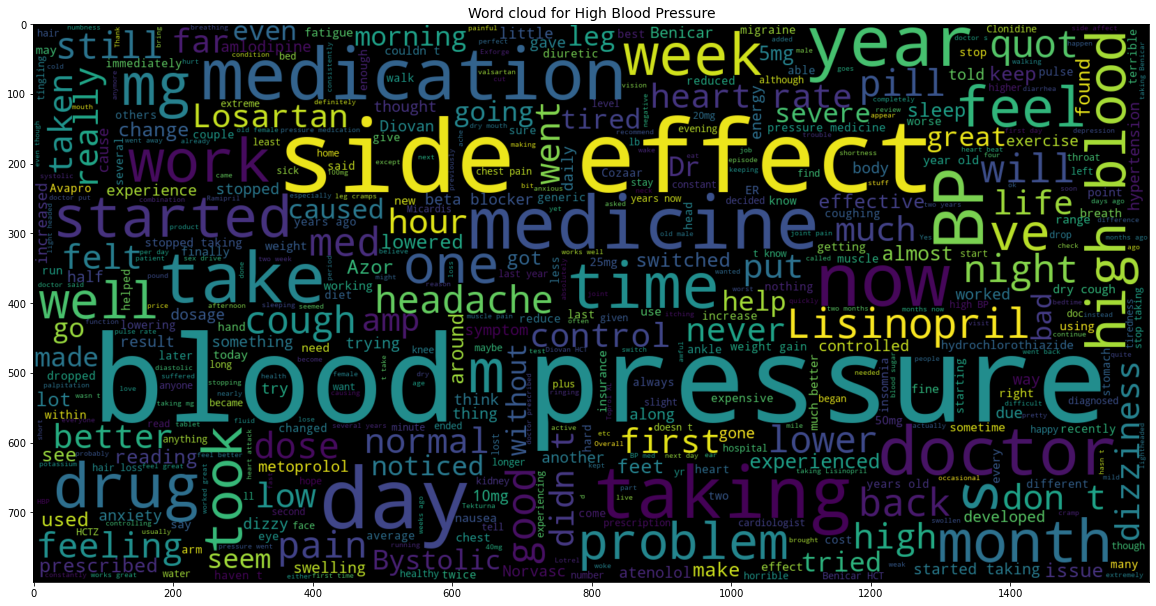

In [14]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_bp.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for High Blood Pressure',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Diabetes Type 2')

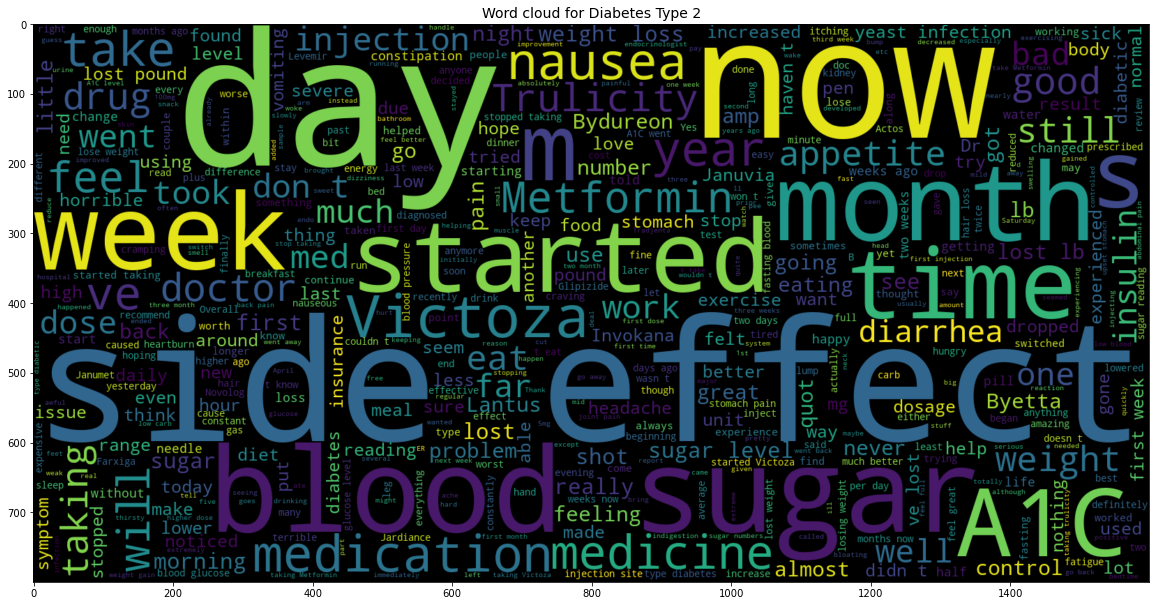

In [15]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_diab.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Diabetes Type 2',fontsize=14)

## data preprocessing

In [16]:
X.head()

,condition,review
2,Birth Control,"""I used to take another oral contraceptive, wh..."
3,Birth Control,"""This is my first time using any form of birth..."
9,Birth Control,"""I had been on the pill for many years. When m..."
11,Depression,"""I have taken anti-depressants for years, with..."
14,Birth Control,"""Started Nexplanon 2 months ago because I have..."


In [21]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

In [17]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer()

In [18]:
from bs4 import BeautifulSoup
import re

**Word Preprocessing Steps Used:**
1. Delete HTML links 
2. Remove every thing other than alphabets and numbers
3. Remove Stopwords(General words)
4. Lower casing the text
5. Lemmatize the words(only root of the words)

In [19]:
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z0-9]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stop]
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmitize_words))

In [22]:
X['review_clean'] = X['review'].apply(review_to_words)

In [ ]:
X.head()

,condition,review,review_clean
2,Birth Control,"""I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas.""",used take another oral contraceptive 21 pill cycle happy light period max 5 day side effect contained hormone gestodene available u switched lybrel ingredient similar pill ended started lybrel immediately first day period instruction said period lasted two week taking second pack two week third pack thing got even worse third period lasted two week end third week still daily brown discharge positive side side effect idea period free tempting ala
3,Birth Control,"""This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch""",first time using form birth control glad went patch 8 month first decreased libido subsided downside made period longer 5 6 day exact used period 3 4 day max also made cramp intense first two day period never cramp using birth control happy patch
9,Birth Control,"""I had been on the pill for many years. When my doctor changed my RX to chateal, it was as effective. It really did help me by completely clearing my acne, this takes about 6 months though. I did not gain extra weight, or develop any emotional health issues. I stopped taking it bc I started using a more natural method of birth control, but started to take it bc I hate that my acne came back at age 28. I really hope symptoms like depression, or weight gain do not begin to affect me as I am older now. I&#039;m also naturally moody, so this may worsen things. I was in a negative mental rut today. Also I hope this doesn&#039;t push me over the edge, as I believe I am depressed. Hopefully it&#039;ll be just like when I was younger.""",pill many year doctor changed rx chateal effective really help completely clearing acne take 6 month though gain extra weight develop emotional health issue stopped taking bc started using natural method birth control started take bc hate acne came back age 28 really hope symptom like depression weight gain begin affect older also naturally moody may worsen thing negative mental rut today also hope push edge believe depressed hopefully like younger
11,Depression,"""I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects.""",taken anti depressant year improvement mostly moderate severe side affect make go take cymbalta mostly pain began deplin noticed major improvement overnight energy better disposition sinking low low major depression taking 3 month feel like normal person first time ever best thing side effect
14,Birth Control,"""Started Nexpl

## Creating features and Target Variable

In [23]:
X_feat=X['review_clean']
y=X['condition']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Bag of Words

In [27]:
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train)

count_test = count_vectorizer.transform(X_test)

In [28]:
from collections import Counter
from imblearn.over_sampling import SMOTE 
Counter(y_train)# Before
smt=SMOTE()
count_train_sm,y_train_sm=smt.fit_resample(count_train,y_train)
Counter(y_train_sm)


Counter({'Depression': 23030,
         'Birth Control': 23030,
         'High Blood Pressure': 23030,
         'Diabetes, Type 2': 23030})

## Machine Learning Model : Naive Bayes

accuracy:   0.973
Confusion matrix, without normalization


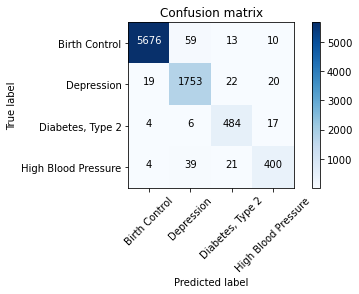

In [29]:
mnb = MultinomialNB()
mnb.fit(count_train_sm, y_train_sm)
pred = mnb.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## Machine Learning Model : Passive Aggressive Classifier

accuracy:   0.973
Confusion matrix, without normalization


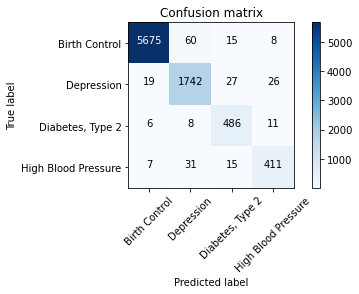

In [30]:
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression

passive = PassiveAggressiveClassifier()
passive.fit(count_train_sm, y_train_sm)
pred = passive.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

### TFIDF

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)
smt=SMOTE()
tfidf_train_2_sm,y_train_sm=smt.fit_resample(tfidf_train_2,y_train)
Counter(y_train_sm)

Counter({'Depression': 23030,
         'Birth Control': 23030,
         'High Blood Pressure': 23030,
         'Diabetes, Type 2': 23030})

## Machine Learning Model : Naive Bayes

accuracy:   0.972
Confusion matrix, without normalization


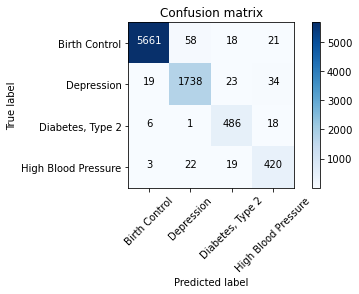

In [34]:
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2_sm, y_train_sm)
pred = mnb_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## Machine Learning Model TFIDF

accuracy:   0.982
Confusion matrix, without normalization


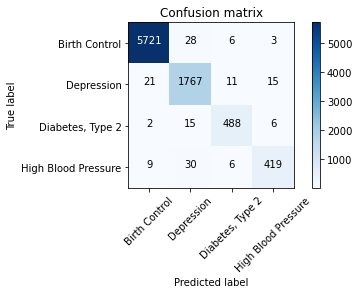

In [35]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)
smt=SMOTE()
tfidf_train_sm,y_train_sm=smt.fit_resample(tfidf_train,y_train)
Counter(y_train_sm)
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_sm, y_train_sm)
pred = pass_tf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])


## TFIDF: Bigrams

In [36]:
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)
smt=SMOTE()
tfidf_train_2_sm,y_train_sm=smt.fit_resample(tfidf_train_2,y_train)
Counter(y_train_sm)

Counter({'Depression': 23030,
         'Birth Control': 23030,
         'High Blood Pressure': 23030,
         'Diabetes, Type 2': 23030})

accuracy:   0.984
Confusion matrix, without normalization


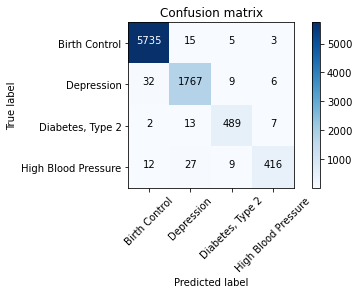

In [37]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2_sm, y_train_sm)
pred = pass_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## TFIDF : Trigrams

accuracy:   0.980
Confusion matrix, without normalization


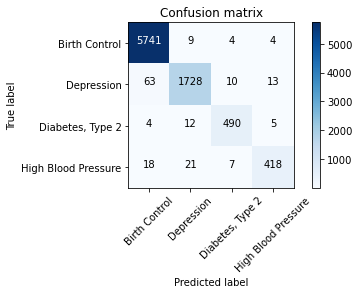

In [38]:
tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer3.transform(X_test)
smt=SMOTE()
tfidf_train_3_sm,y_train_sm=smt.fit_resample(tfidf_train_3,y_train)
Counter(y_train_sm)
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_3_sm, y_train_sm)
pred = pass_tf.predict(tfidf_test_3)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

In [39]:
accuracy_scores=[]
for n in range(1,10):
    tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,n))
    tfidf_train_3 = tfidf_vectorizer3.fit_transform(X_train)
    tfidf_test_3 = tfidf_vectorizer3.transform(X_test)
    smt=SMOTE()
    tfidf_train_3_sm,y_train_sm=smt.fit_resample(tfidf_train_3,y_train)
    Counter(y_train_sm)
    pass_tf = PassiveAggressiveClassifier()
    pass_tf.fit(tfidf_train_3_sm, y_train_sm)
    pred = pass_tf.predict(tfidf_test_3)
    score = metrics.accuracy_score(y_test, pred)
    accuracy_scores.append(score)
    
    

    

BiGram works best


2

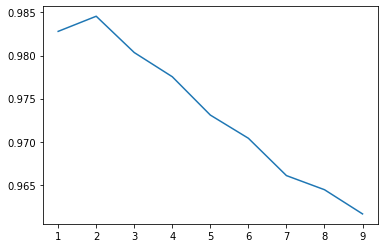

In [40]:
plt.plot(range(1,10),accuracy_scores)
np.argmax(accuracy_scores)+1

## Most important Features

<AxesSubplot:xlabel='0', ylabel='1'>

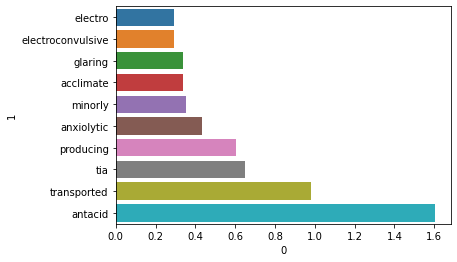

In [41]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names_out()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]
    
    return topn



birth_control=pd.DataFrame(most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Birth Control'))

sns.barplot(x=0,y=1,data=birth_control)


<AxesSubplot:xlabel='0', ylabel='1'>

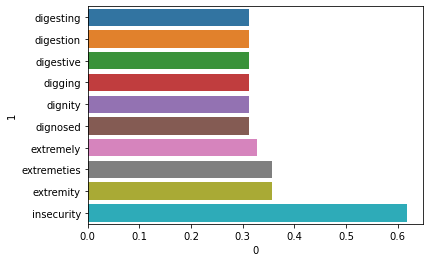

In [42]:
depression=pd.DataFrame(most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Depression'))
sns.barplot(x=0,y=1,data=depression)

<AxesSubplot:xlabel='0', ylabel='1'>

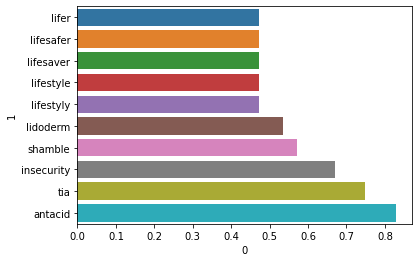

In [43]:
hbp=pd.DataFrame(most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'High Blood Pressure'))
sns.barplot(x=0,y=1,data=hbp)

<AxesSubplot:xlabel='0', ylabel='1'>

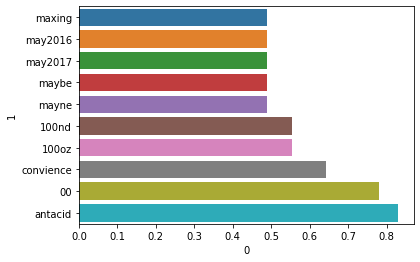

In [44]:
diab=pd.DataFrame(most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Diabetes, Type 2'))
sns.barplot(x=0,y=1,data=diab)

### Results ###
- 0.984 accuracy is shown by BIgram language model is the best out of all
- For diabetes, Type 2, High Blood Pressure and Birth Control the most important feature/word is 'antacid'
- For depression it is 'Insecurity'
